In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from bs4 import BeautifulSoup
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.patches as patches

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:

def generate_box(obj):
    
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0

def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([image_id])
        # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target


In [3]:
imgs = list(sorted(os.listdir("images/")))

In [4]:
labels = list(sorted(os.listdir("annotations/")))

In [5]:
class MaskDataset(object):
    def __init__(self, transforms):
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir("images/")))
#         self.labels = list(sorted(os.listdir("/kaggle/input/face-mask-detection/annotations/")))

    def __getitem__(self, idx):
        # load images ad masks
        file_image = 'maksssksksss'+ str(idx) + '.png'
        file_label = 'maksssksksss'+ str(idx) + '.xml'
        img_path = os.path.join("images/", file_image)
        label_path = os.path.join("annotations/", file_label)
        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(idx, label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [17]:
data_transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)


In [7]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform)
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=4, collate_fn=collate_fn)

In [8]:
torch.cuda.is_available()

False

In [36]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
model = torch.nn.Sequential(*list(model.children())[:])
rcnn_transform = torch.nn.Sequential(list(model.children())[0])
ResNet = torch.nn.Sequential(list(list(model.children())[1].children())[0])
FPN = torch.nn.Sequential(list(list(model.children())[1].children())[1])
RPN = torch.nn.Sequential(list(model.children())[2])
ROI_Head = torch.nn.Sequential(list(model.children())[3])
print(FPN)

Sequential(
  (0): FeaturePyramidNetwork(
    (inner_blocks): ModuleList(
      (0): Conv2dNormActivation(
        (0): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
      )
      (1): Conv2dNormActivation(
        (0): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
      )
      (2): Conv2dNormActivation(
        (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
      )
      (3): Conv2dNormActivation(
        (0): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (layer_blocks): ModuleList(
      (0): Conv2dNormActivation(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): Conv2dNormActivation(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (2): Conv2dNormActivation(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (3): Conv2dNormActivation(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1)

# Model

In [11]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [12]:
model = get_model_instance_segmentation(3)

/opt/miniconda3/envs/image/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/miniconda3/envs/image/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    break

[{'boxes': tensor([[ 79., 105., 109., 142.],
        [185., 100., 226., 144.],
        [325.,  90., 360., 141.]]), 'labels': tensor([0, 1, 0]), 'image_id': tensor([0])}, {'boxes': tensor([[321.,  34., 354.,  69.],
        [224.,  38., 261.,  73.],
        [299.,  58., 315.,  81.],
        [143.,  74., 174., 115.],
        [ 74.,  69.,  95.,  99.],
        [191.,  67., 221.,  93.],
        [ 21.,  73.,  44.,  93.],
        [369.,  70., 398.,  99.],
        [ 83.,  56., 111.,  89.]]), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0]), 'image_id': tensor([1])}, {'boxes': tensor([[ 68.,  42., 105.,  69.],
        [154.,  47., 178.,  74.],
        [238.,  34., 262.,  69.],
        [333.,  31., 366.,  65.]]), 'labels': tensor([1, 1, 1, 2]), 'image_id': tensor([2])}, {'boxes': tensor([[ 52.,  53.,  73.,  76.],
        [ 72.,  53.,  92.,  75.],
        [112.,  51., 120.,  68.],
        [155.,  60., 177.,  83.],
        [189.,  59., 210.,  80.],
        [235.,  57., 257.,  78.],
        [289.,  60.

# Train Model

In [14]:
num_epochs = 1
model.to(device)

# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
#         print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
        epoch_loss += losses
    print(epoch_loss)


tensor(89.7635, grad_fn=<AddBackward0>)


In [15]:
for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        break

In [16]:
model.eval()
preds = model(imgs)
preds

[{'boxes': tensor([[186.0975,  93.7933, 227.2643, 150.6248],
          [ 25.0832, 142.5913,  41.4871, 163.4875],
          [ 76.2333, 104.9954, 111.2765, 146.8023],
          [326.1233,  94.8274, 360.6579, 143.4398],
          [109.4051, 102.5706, 125.7646, 126.5927],
          [ 10.5578, 140.9326,  61.6117, 233.0654],
          [469.8430, 119.2379, 488.9807, 143.4617],
          [444.6021, 187.3960, 458.8730, 209.7602],
          [457.1769, 170.0068, 493.5903, 203.1853],
          [113.4796, 126.6551, 147.6222, 163.9703],
          [436.5242, 180.6783, 491.0378, 277.5445],
          [ 38.2900,  88.9605,  77.7547, 155.5673],
          [ 41.6866, 108.8678,  78.0951, 145.1497],
          [451.4436, 122.4091, 470.5646, 141.9835],
          [329.9704, 117.9124, 356.5634, 143.8260],
          [315.7927,  81.8969, 362.7949, 153.7809],
          [406.6483, 105.2696, 496.7035, 192.2269],
          [ 43.8837, 259.4567,  55.7594, 288.1781],
          [ 92.7261,   1.9663, 138.0692,  73.8236],
   

# Function to plot image

In [20]:
def plot_image(img_tensor, annotation):
    
    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data

    # Display the image
    ax.imshow(img.permute(1, 2, 0))
    
    for box in annotation["boxes"]:
        xmin, ymin, xmax, ymax = box

        # Create a Rectangle patch
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

Prediction


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

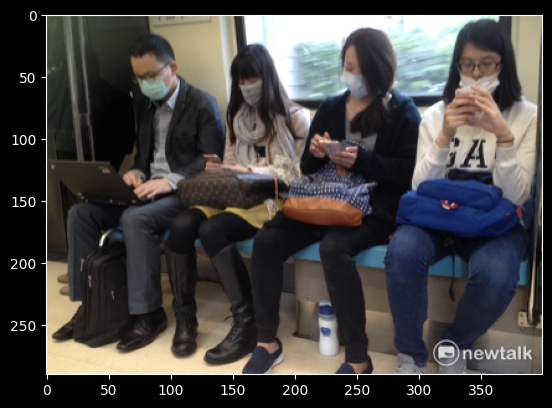

In [21]:
print("Prediction")
plot_image(imgs[2], preds[2])
print("Target")
plot_image(imgs[2], annotations[2])

In [ ]:
torch.save(model.state_dict(),'model.pt')

In [ ]:
model2 = get_model_instance_segmentation(3)

# Save Model

In [ ]:
model2.load_state_dict(torch.load('model.pt'))
model2.eval()
model2.to(device)

# Load Model

In [ ]:
pred2 = model2(imgs)

In [19]:
print("Predict with loaded model")
plot_image(imgs[3], pred2[3])

Predict with loaded model


NameError: name 'pred2' is not defined